# Import the dependencies

In [1]:
import re
import random
import numpy as np
import pandas as pd

from tqdm import tqdm

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.callbacks import ModelCheckpoint

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from matplotlib import pyplot as plt

import sys
import time

from collections import Counter

sys.path.append("../")
from calculus_path_mod.terms.pseudonym import *
from calculus_path_mod.reduction_strategy import *
from calculus_path_mod.terms.arithm_complex_ops import *

In [50]:
epochs = 35
num_neurons = 128
onehot_dims = 4

# Load & Prepare the data

In [3]:
enc_dict = {"(": [1.0, .0, .0, .0],
            ")": [.0, 1.0, .0, .0],
            "x": [.0, .0, 1.0, .0],
            "@x.": [.0, .0, .0, 1.0]}
tokens_pattern = r"(\(|\)|@x\.|x)"


def tokenize_data(simplified_term):
    return re.findall(tokens_pattern, simplified_term)


def tokenize_and_vectorize(x_data):
    vectorized_data_ = []
    for sample_ in x_data:
        tokens_ = tokenize_data(sample_)
        sample_vecs_ = []
        for token_ in tokens_:
            try:
                sample_vecs_.append(enc_dict[token_])
            except KeyError:
                pass
        vectorized_data_.append(sample_vecs_)
    return vectorized_data_

In [5]:
all_data = pd.read_csv("./data/steps_simple_term_str.csv", delimiter=',')

# leave only unique terms
print(f"Count all terms: {len(all_data)}\n")
all_data = all_data.drop_duplicates(subset="simple_terms").reset_index(drop=True)
print(f"Count original terms: {len(all_data)}\n")

# shuffle the dataset
all_data = shuffle(all_data, random_state=33).reset_index(drop=True)

print(f"max steps count: {max(all_data['steps_num_lo'])}")
print(f"min steps count: {min(all_data['steps_num_lo'])}")

Count all terms: 4251

Count original terms: 4251

max steps count: 219
min steps count: 0


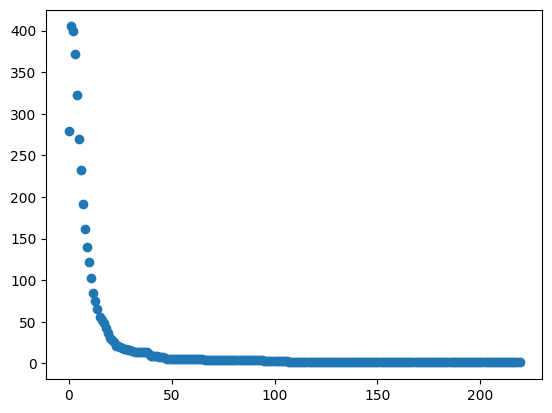

In [6]:
counter = Counter(all_data['steps_num_lo'])
counter = dict(counter)

plt.scatter(counter.keys(), counter.values())

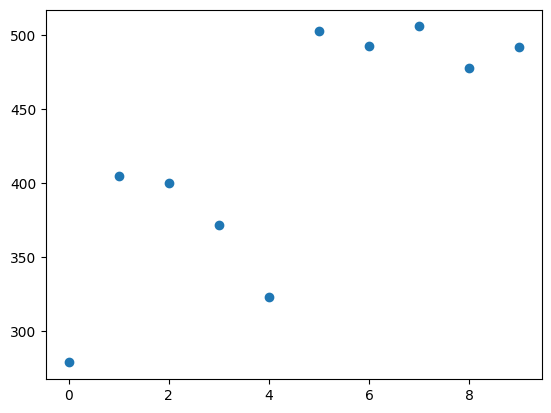

In [38]:
# max count terms in one bin are 500:

bin_edges = [1, 2, 3, 4, 5, 7, 10, 16, 36]

counter = Counter(np.digitize(all_data['steps_num_lo'], bin_edges))
counter = dict(counter)

plt.scatter(counter.keys(), counter.values())

In [40]:
# make test/train split
x_train, x_test, y_train, y_test = train_test_split(all_data["simple_terms"].tolist(), all_data["steps_num_lo"].tolist(),
                                                    test_size=0.2, random_state=42)

print(f"Count training samples: {len(y_train)}")
print(f"Count testing samples: {len(y_test)}")

Count training samples: 3400
Count testing samples: 851


In [41]:
# one-hot encode y-data
encoder = LabelBinarizer()
encoder.fit(range(0, 10))

y_train = np.digitize(y_train, bin_edges)
y_test = np.digitize(y_test, bin_edges)

y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

x_train = tokenize_and_vectorize(x_train)
x_test = tokenize_and_vectorize(x_test)

In [42]:
xy_train_data = list(zip(x_train, y_train))
xy_test_data = list(zip(x_test, y_test))

In [43]:
print(f"len(test_data) = {len(xy_test_data)}")
print(f"len(train_data) = {len(xy_train_data)}")

len(test_data) = 851
len(train_data) = 3400


In [44]:
def train_generator():
    while True:
        random.shuffle(xy_train_data)
        for xtd, ytd in xy_train_data:
            yield np.array([xtd]), np.array([ytd])


def val_generator():
    while True:
        for xtd, ytd in xy_test_data:
            yield np.array([xtd]), np.array([ytd])

# Define the model

In [62]:
model = Sequential()
model.add(LSTM(units=num_neurons,
               input_shape=(None, onehot_dims)))
model.add(Dense(units=10, activation='softmax'))

In [63]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               68096     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 69386 (271.04 KB)
Trainable params: 69386 (271.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [64]:
model_structure = model.to_json()
with open("./fine_models/v1.3_lstm_bin_steps_pred.json", 'w') as json_file:
    json_file.write(model_structure)

In [65]:
# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='./fine_models/v1.3_lstm_bin_steps_pred.h5',  # Specify the path to save the best model
    monitor='accuracy',  # Metric to monitor (e.g., validation loss)
    save_best_only=True,  # Save only the best model
    mode='max',  # 'min' or 'max' depending on the monitored metric
    verbose=0  # Print a message when saving the model
)

In [66]:
history = model.fit(train_generator(), steps_per_epoch=3400, validation_data=val_generator(), validation_steps=851, epochs=epochs, verbose=1, callbacks=[checkpoint_callback])

Epoch 1/35
3400/3400 [==============================] - 187s 54ms/step - loss: 2.2927 - accuracy: 0.1226 - val_loss: 2.2751 - val_accuracy: 0.1704
Epoch 2/35
   1/3400 [..............................] - ETA: 4:21 - loss: 2.2485 - accuracy: 0.0000e+00

D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3400/3400 [==============================] - 150s 44ms/step - loss: 2.2037 - accuracy: 0.1882 - val_loss: 2.1720 - val_accuracy: 0.2092
Epoch 3/35
3400/3400 [==============================] - 152s 45ms/step - loss: 2.0778 - accuracy: 0.2288 - val_loss: 1.9887 - val_accuracy: 0.2421
Epoch 4/35
3400/3400 [==============================] - 143s 42ms/step - loss: 2.0028 - accuracy: 0.2456 - val_loss: 1.8378 - val_accuracy: 0.3008
Epoch 5/35
3400/3400 [==============================] - 138s 41ms/step - loss: 1.8384 - accuracy: 0.2938 - val_loss: 1.8688 - val_accuracy: 0.2879
Epoch 6/35
3400/3400 [==============================] - 137s 40ms/step - loss: 1.7966 - accuracy: 0.3247 - val_loss: 2.1855 - val_accuracy: 0.1892
Epoch 7/35
3400/3400 [==============================] - 138s 41ms/step - loss: 2.0267 - accuracy: 0.2485 - val_loss: 1.9677 - val_accuracy: 0.2526
Epoch 8/35
3400/3400 [==============================] - 135s 40ms/step - loss: 1.8075 - accuracy: 0.3215 - val_loss: 1.9057 - val

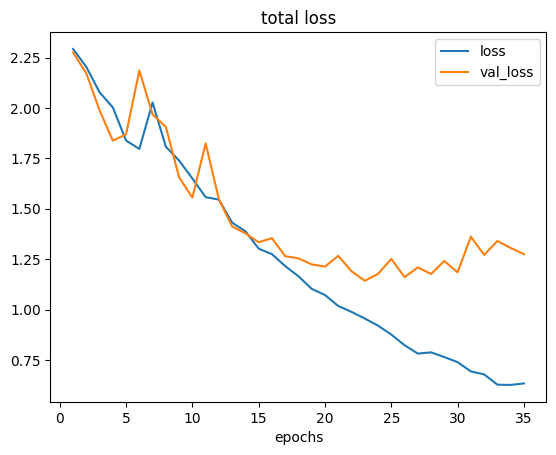

In [71]:
plt.plot(range(1, epochs + 1), history.history["loss"], label="loss")
plt.plot(range(1, epochs + 1), history.history["val_loss"], label="val_loss")
plt.xlabel("epochs")
plt.title("total loss")

plt.legend()
plt.show()

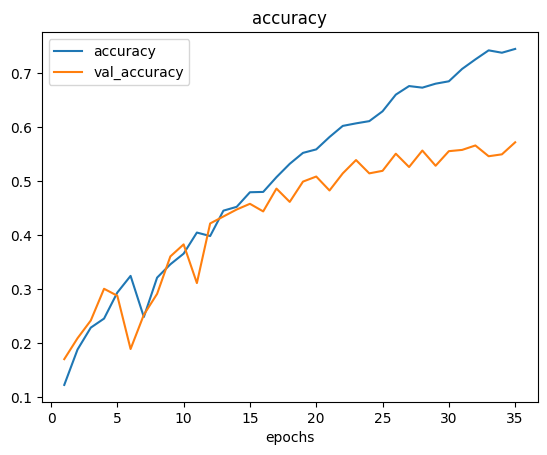

In [72]:
plt.plot(range(1, epochs + 1), history.history["accuracy"], label="accuracy")
plt.plot(range(1, epochs + 1), history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("epochs")
plt.title("accuracy")

plt.legend()
plt.show()

In [73]:
y_test_pred = []
for x_ in x_test:
    y_test_pred.append(model.predict(np.array([x_]), verbose=0)[0])

In [74]:
def draw_pred_lines(y_pred, y_real):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    for key_, val_ in drawing_df.items():
        plt.plot(range(len(val_)), val_, label=key_)

    plt.xlabel("No")
    plt.ylabel("Redexes count")
    plt.title("Pred vs Real Step Time")
    plt.legend()
    plt.show()

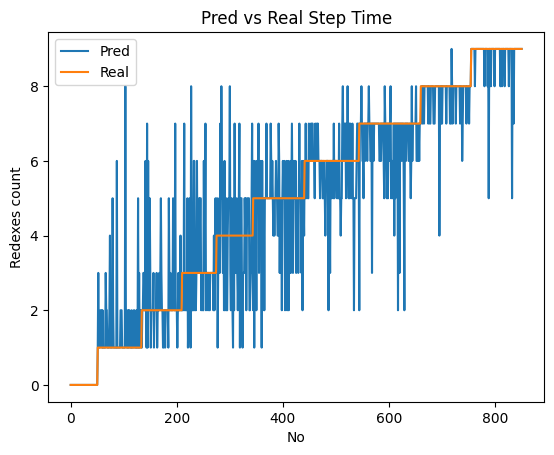

In [75]:
y_test_pred_nums = encoder.inverse_transform(np.array(y_test_pred))
y_test_nums = encoder.inverse_transform(y_test)

draw_pred_lines(y_test_pred_nums, y_test_nums)

In [76]:
def calculate_accuracy(actual_labels, predicted_labels):
    correct_predictions = sum(1 for actual, predicted in zip(actual_labels, predicted_labels) if actual == predicted)
    total_predictions = len(actual_labels)
    accuracy = correct_predictions / total_predictions
    return accuracy


print("Test accuracy:", calculate_accuracy(y_test_nums, y_test_pred_nums))

Test accuracy: 0.5722679200940071


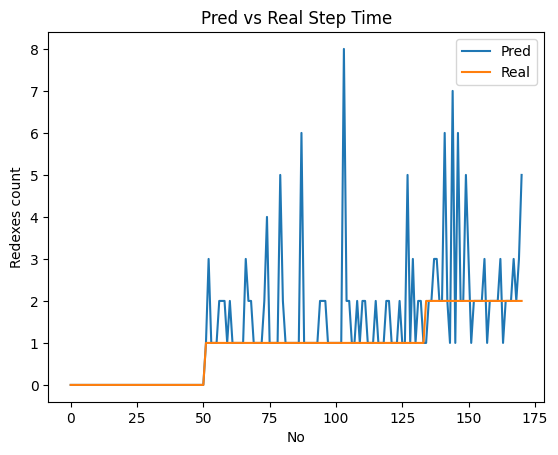

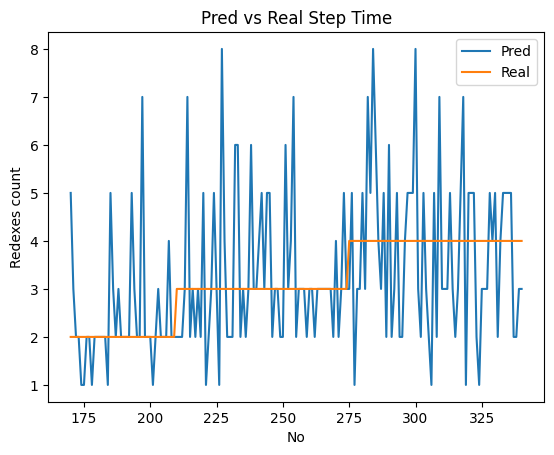

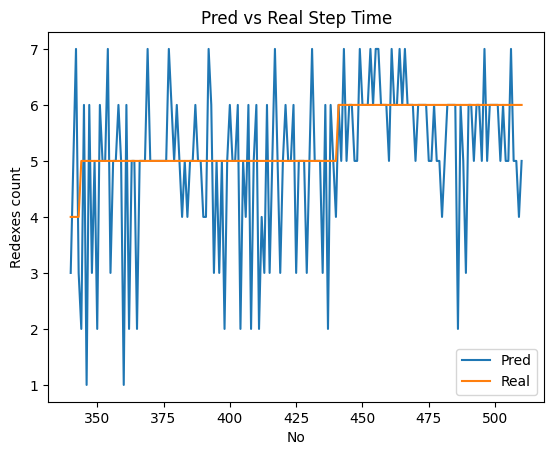

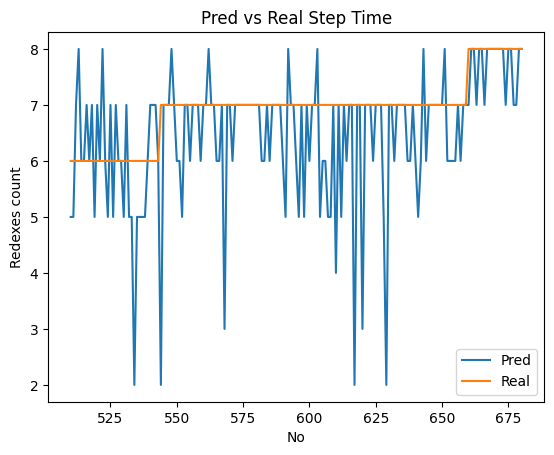

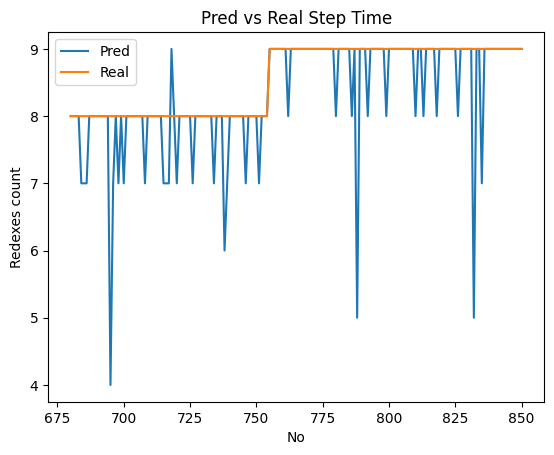

In [77]:
def draw_pred_lines_steps(y_pred, y_real, ranges):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    range_step = int(len(y_pred) / ranges)
    for range_no in range(ranges):
        for key_, val_ in drawing_df.items():
            plt.plot(range(range_no * range_step, ((range_no + 1) * range_step) + 1), val_[range_no * range_step : ((range_no + 1) * range_step) + 1], label=key_)

        plt.xlabel("No")
        plt.ylabel("Redexes count")
        plt.title("Pred vs Real Step Time")
        plt.legend()
        plt.show()


draw_pred_lines_steps(y_test_pred_nums, y_test_nums, 5)

Train accuracy: 0.7826470588235294


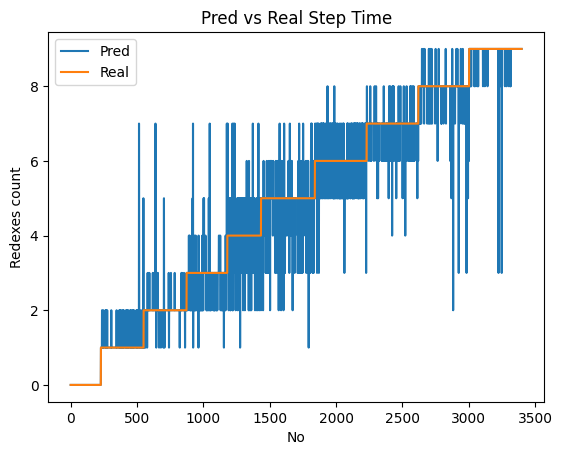

In [78]:
y_train_pred = []
for x_ in x_train:
    y_train_pred.append(model.predict(np.array([x_]), verbose=0)[0])

y_train_pred_nums = encoder.inverse_transform(np.array(y_train_pred))
y_train_nums = encoder.inverse_transform(y_train)

print("Train accuracy:", calculate_accuracy(y_train_nums, y_train_pred_nums))

draw_pred_lines(y_train_pred_nums, y_train_nums)

In [79]:
y_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [80]:
def ite_term():
    x, y, c = Var(), Var(), Var()
    x_, y_, c_ = Atom(x), Atom(y), Atom(c)
    return Lambda(c, Lambda(x, Lambda(y, multi_app_term(c_, x_, y_))))


def true_term():
    x, y = Var(), Var()
    x_ = Atom(x)
    return Lambda(x, Lambda(y, x_))


def num_zero_term():
    s, z = Var(), Var()
    z_ = Atom(z)
    return Lambda(s, Lambda(z, z_))


def num_term(n: int):
    if n <= 0:
        return num_zero_term()
    s, z = Var(), Var()
    s_, z_ = Atom(s), Atom(z)
    core_term = App(s_, z_)
    for _ in range(n - 1):
        core_term = App(s_, core_term)
    return Lambda(s, Lambda(z, core_term))


def multi_app_term(term_0: Term, term_1: Term, *terms: Term):
    res_app_term = App(term_0, term_1)
    for term in terms:
        res_app_term = App(res_app_term, term)
    return res_app_term


def false_term():
    x, y = Var(), Var()
    y_ = Atom(y)
    return Lambda(x, Lambda(y, y_))


def pair_term():
    x, y, p = Var(), Var(), Var()
    x_, y_, p_ = Atom(x), Atom(y), Atom(p)
    return Lambda(x, Lambda(y, Lambda(p, multi_app_term(p_, x_, y_))))


def first_term():
    p = Var()
    p_ = Atom(p)
    return Lambda(p, App(p_, true_term()))


def second_term():
    p = Var()
    p_ = Atom(p)
    return Lambda(p, App(p_, false_term()))


def succ_term():
    x, y, n = Var(), Var(), Var()
    x_, y_, n_ = Atom(x), Atom(y), Atom(n)
    return Lambda(n, Lambda(x, Lambda(y, App(x_, multi_app_term(n_, x_, y_)))))


def sinc_term():
    p = Var()
    p_ = Atom(p)
    return Lambda(
        p,
        multi_app_term(
            pair_term(),
            App(second_term(), p_),
            App(succ_term(), App(second_term(), p_)),
        ),
    )


def pred_term():
    n, f, x, g, h, u = Var(), Var(), Var(), Var(), Var(), Var()
    n_, f_, x_ = Atom(n), Atom(f), Atom(x)
    g_, h_, u_ = Atom(g), Atom(h), Atom(u)

    return Lambda(n, Lambda(f, Lambda(x, multi_app_term(
        n_,
        Lambda(g, Lambda(h, App(h_, App(g_, f_)))),
        Lambda(u, x_),
        Lambda(u, u_)
    ))))


def plus_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(m, Lambda(n, multi_app_term(n_, succ_term(), m_)))


def subtract_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(n, Lambda(m, multi_app_term(m_, pred_term(), n_)))


def iszero_term():
    x, n = Var(), Var()
    n_ = Atom(n)
    return Lambda(n, App(App(n_, Lambda(x, false_term())), true_term()))


def leq_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(
        n, Lambda(m, App(iszero_term(), multi_app_term(subtract_term(), n_, m_)))
    )


def and_term():
    a, b = Var(), Var()
    a_, b_ = Atom(a), Atom(b)
    return Lambda(a, Lambda(b, multi_app_term(ite_term(), a_, b_, a_)))


def eq_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(
        n,
        Lambda(
            m,
            multi_app_term(
                and_term(),
                multi_app_term(leq_term(), n_, m_),
                multi_app_term(leq_term(), m_, n_),
            ),
        ),
    )


def i_term():
    x = Var()
    x_ = Atom(x)
    return Lambda(x, x_)


def omega_term(n: int):
    x = Var()
    x_ = Atom(x)
    body_app_term = x_
    for _ in range(n - 1):
        body_app_term = App(body_app_term, x_)
    return Lambda(x, body_app_term)


def multi_i_term(m: int):
    app_term = i_term()
    for _ in range(m - 1):
        app_term = App(app_term, i_term())
    return app_term


def omega_multi_i_term(n: int, m: int):
    return App(omega_term(n), multi_i_term(m))


def term_test_1():
    x, y = Var(), Var()
    x_, y_ = Atom(x), Atom(y)

    return "(λx. (λy.y)) ((λx. (xx)) (λx. (xx))) == I == λx. x", \
        App(
            Lambda(x, Lambda(y, y_)),
            App(
                Lambda(x, App(x_, x_)),
                Lambda(x, App(x_, x_))
            )
        )


def term_test_2():
    return "(ITE TRUE 3 1) == 3 == λx. λy. (x (x (x y)))", \
        multi_app_term(ite_term(), true_term(), num_term(3), num_term(1))


def term_test_3():
    return "(ITE FALSE 0 4) == 4 == λx. λy. (x (x (x (x y))))", \
        multi_app_term(ite_term(), false_term(), num_term(0), num_term(4))


def term_test_4():
    return "(PRED 0) == 0 == λx. λy. y", \
        multi_app_term(pred_term(), num_term(0))


def term_test_5():
    return "(PRED 5) == 4 == λx. λy. (x (x (x (x y))))", \
        multi_app_term(pred_term(), num_term(5))


def term_test_6():
    return "(PLUS 0 0) == 0 == λx. λy. y", \
        multi_app_term(plus_term(), num_term(0), num_term(0))


def term_test_7():
    return "(PLUS 2 3) == 5 == λx. λy. (x (x (x (x (x y)))))", \
        multi_app_term(plus_term(), num_term(2), num_term(3))


def term_test_8():
    return "(SUBTRACT 4 1) == 3 == λx. λy. (x (x (x y)))", \
        multi_app_term(subtract_term(), num_term(4), num_term(1))


def term_test_9():
    return "(SUBTRACT 3 5) == 0 == λx. λy. y", \
        multi_app_term(subtract_term(), num_term(3), num_term(5))


def term_test_10():
    return "(LEQ 3 2) == FALSE == λx. λy. y", \
        multi_app_term(leq_term(), num_term(3), num_term(2))


def term_test_11():
    return "(LEQ 2 5) == TRUE == λx. λy. x", \
        multi_app_term(leq_term(), num_term(2), num_term(5))


def term_test_12():
    return "(EQ 2 2) == TRUE == λx. λy. x", \
        multi_app_term(eq_term(), num_term(2), num_term(2))


def term_test_13():
    return "(EQ 1 4) == FALSE == λx. λy. y", \
        multi_app_term(eq_term(), num_term(1), num_term(4))


def term_test_14():
    return "Omega(3, 3)  == I == λx. x", \
        omega_multi_i_term(3, 3)


def term_test_15():
    return "GCD_vO 5 2", \
        multi_app_term(gcd_term_v0(), num_term(5), num_term(2))


def term_test_16():
    return "GCD_v1 5 2", \
        multi_app_term(gcd_term_v1(), num_term(5), num_term(2))


def term_test_17():
    return "GCD_v3 5 2", \
        multi_app_term(gcd_term_v3(), num_term(5), num_term(2))


def term_test_18():
    return "PYTHAGOREAN 5 2 2", \
        multi_app_term(
            pythagorean_term(), num_term(5), num_term(2), num_term(2)
        )


def test_function(term_deskr_: str, term_: Term, model_: Sequential):
    prediction_ = model_.predict(tokenize_and_vectorize([term_.simple_str()]), verbose=0)
    print(f"{term_deskr_}\nnorm_steps={np.digitize(term_.normalize(LOStrategy())[1], bin_edges)}\tpred_steps={np.argmax(prediction_[0])}\n")


list_test_functions = (term_test_1, term_test_2, term_test_3, term_test_4, term_test_5, term_test_6, term_test_7, term_test_9, term_test_10, term_test_11, term_test_12, term_test_13, term_test_14, term_test_15, term_test_16, term_test_17, term_test_18)

for term_function in list_test_functions:
    term_deskr, term = term_function()
    test_function(term_deskr, term, model)

(λx. (λy.y)) ((λx. (xx)) (λx. (xx))) == I == λx. x
norm_steps=1	pred_steps=1

(ITE TRUE 3 1) == 3 == λx. λy. (x (x (x y)))
norm_steps=5	pred_steps=5

(ITE FALSE 0 4) == 4 == λx. λy. (x (x (x (x y))))
norm_steps=5	pred_steps=5

(PRED 0) == 0 == λx. λy. y
norm_steps=4	pred_steps=2

(PRED 5) == 4 == λx. λy. (x (x (x (x y))))
norm_steps=7	pred_steps=2

(PLUS 0 0) == 0 == λx. λy. y
norm_steps=4	pred_steps=5

(PLUS 2 3) == 5 == λx. λy. (x (x (x (x (x y)))))
norm_steps=7	pred_steps=8

(SUBTRACT 3 5) == 0 == λx. λy. y
norm_steps=9	pred_steps=5

(LEQ 3 2) == FALSE == λx. λy. y
norm_steps=8	pred_steps=3

(LEQ 2 5) == TRUE == λx. λy. x
norm_steps=9	pred_steps=3

(EQ 2 2) == TRUE == λx. λy. x
norm_steps=9	pred_steps=7

(EQ 1 4) == FALSE == λx. λy. y
norm_steps=9	pred_steps=8

Omega(3, 3)  == I == λx. x
norm_steps=6	pred_steps=5

GCD_vO 5 2
norm_steps=9	pred_steps=7

GCD_v1 5 2
norm_steps=9	pred_steps=8

GCD_v3 5 2
norm_steps=9	pred_steps=8

PYTHAGOREAN 5 2 2
norm_steps=9	pred_steps=7



In [81]:
list_simplified_omega_terms = []

for n in range(1, 21):
    for m in range(1, 21):
        term_ = omega_multi_i_term(n, m)
        list_simplified_omega_terms.append(term_.simple_str())

list_simplified_omega_terms = tokenize_and_vectorize(list_simplified_omega_terms)

real_redexes_count = []

for n in range(1, 21):
    for m in range(1, 21):
        term_ = omega_multi_i_term(n, m)
        real_redexes_count.append(np.digitize(term_.normalize(LOStrategy())[1], bin_edges))

predictions_omega_terms_redexes = []
for rec_ in tqdm(list_simplified_omega_terms):
    predictions_omega_terms_redexes.append(np.argmax(model.predict([rec_], verbose=0)[0]))

100%|██████████| 400/400 [00:30<00:00, 12.97it/s]


In [82]:
print(predictions_omega_terms_redexes)

[1, 2, 3, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 2, 3, 5, 8, 8, 8, 7, 7, 7, 8, 7, 8, 7, 8, 7, 8, 7, 8, 7, 8, 3, 5, 5, 6, 7, 7, 7, 7, 7, 7, 7, 8, 7, 8, 7, 8, 7, 8, 7, 8, 3, 5, 5, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 7, 8, 7, 8, 3, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 7, 8, 7, 8, 7, 8, 3, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 7, 8, 3, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 3, 5, 5, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 5, 5, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 5, 5, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 5, 5, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 5, 5, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 5, 5, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 5, 5, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 5, 5, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 5, 5, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 5, 5, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 

In [83]:
print(real_redexes_count)

[1, 2, 3, 4, 5, 5, 6, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 2, 4, 5, 6, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 3, 5, 6, 7, 7, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 4, 6, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 5, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 5, 7, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 6, 7, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 6, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 6, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 7, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 7, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 7, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 7, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 7, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 7, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 

In [84]:
def calculate_accuracy(actual_labels, predicted_labels):
    correct_predictions = sum(1 for actual, predicted in zip(actual_labels, predicted_labels) if actual == predicted)
    total_predictions = len(actual_labels)
    accuracy = correct_predictions / total_predictions
    return accuracy


print("Test accuracy:", calculate_accuracy(real_redexes_count, predictions_omega_terms_redexes))

Test accuracy: 0.0575


In [85]:
green_dots = []
red_dots = []

for n in range(0, 20):
    for m in range(0, 20):
        val = predictions_omega_terms_redexes[n * 20 + m]
        val_real = real_redexes_count[n * 20 + m]

        if val == val_real:
            green_dots.append((n+1, m+1))
        else:
            red_dots.append((n+1, m+1))


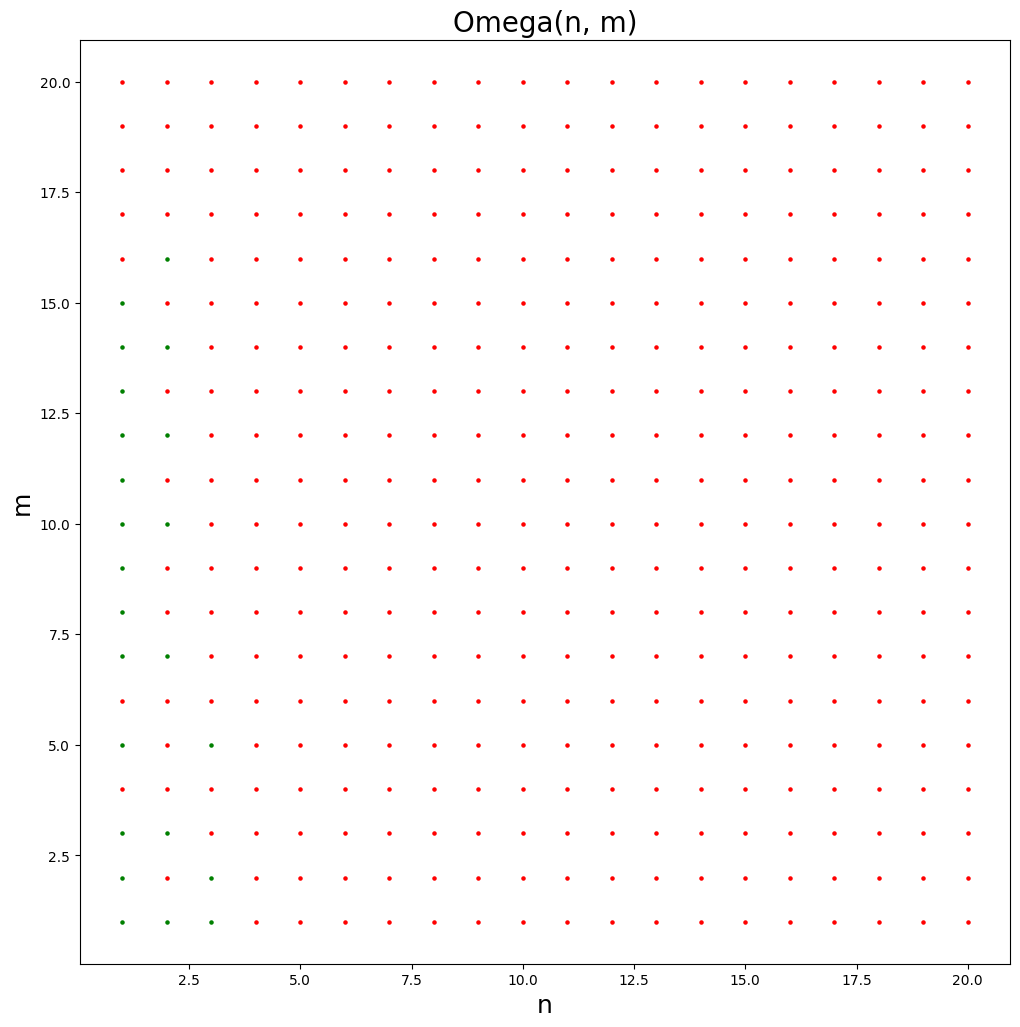

In [86]:
plt.figure(figsize=(12, 12))

green_dots = np.array(green_dots)
red_dots = np.array(red_dots)

plt.scatter(green_dots[:,0], green_dots[:,1], s=5, c='green',)
plt.scatter(red_dots[:,0], red_dots[:,1], s=5, c='red',)

plt.xlabel("n", fontsize=18)
plt.ylabel("m", fontsize=18)
plt.title("Omega(n, m)", fontsize=20)
plt.show()

# Additional metrics evaluation

## Mean Squared Error

In [94]:
_, _, y_train_, y_test_ = train_test_split(all_data["simple_terms"].tolist(), all_data["steps_num_lo"].tolist(),
                                           test_size=0.2, random_state=42)
mapper = pd.DataFrame({"y_train_steps": y_train_}).groupby(y_train_nums).mean().to_dict()
mapper = mapper["y_train_steps"]

In [87]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score

In [95]:
mse_train = mean_squared_error(y_train_, [mapper[y_] for y_ in y_train_pred_nums])
print("Train {Mean Squared Error}:", mse_train)

mse_test = mean_squared_error(y_test_, [mapper[y_] for y_ in y_test_pred_nums])
print("Test {Mean Squared Error}:", mse_test)

Train {Mean Squared Error}: 280.70426677238197
Test {Mean Squared Error}: 315.62761034730426


## Mean Absolute Error

In [97]:
mae_train = mean_absolute_error(y_train_, [mapper[y_] for y_ in y_train_pred_nums])
print("Train {Mean Absolute Error}:", mae_train)

mae_test = mean_absolute_error(y_test_, [mapper[y_] for y_ in y_test_pred_nums])
print("Test {Mean Absolute Error}:", mae_test)

Train {Mean Absolute Error}: 5.776642142455493
Test {Mean Absolute Error}: 6.231874860197579


## Mean Absolute Percentage Error

In [100]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true_fix = np.array([y_ + 0.0001 for y_ in y_true])
    percentage_errors = np.abs((y_true - y_pred) / y_true_fix) * 100
    mape = np.mean(percentage_errors)
    return mape


mape_train = mean_absolute_percentage_error(y_train_, np.array([mapper[y_] for y_ in y_train_pred_nums]))
print("Train {Mean Absolute Percentage Error}:", mape_train)

mape_test = mean_absolute_percentage_error(y_test_, np.array([mapper[y_] for y_ in y_test_pred_nums]))
print("Test {Mean Absolute Percentage Error}:", mape_test)

Train {Mean Absolute Percentage Error}: 20.786229455392785
Test {Mean Absolute Percentage Error}: 39.05722954294526


## Percentage of Explained Variance (PEV)

In [101]:
# Calculate Variance of the target variable
variance_y_test = np.var(y_test_)
variance_y_train = np.var(y_train_)

# Calculate Percentage of Explained Variance (PEV)
pev_test = (1 - mse_test / variance_y_test) * 100
pev_train = (1 - mse_train / variance_y_train) * 100

print("Train {Percentage of Explained Variance}:", pev_train)
print("Test {Percentage of Explained Variance}:", pev_test)

Train {Percentage of Explained Variance}: 71.58994833632246
Test {Percentage of Explained Variance}: 69.79048041068016


## Mean Bias Deviation

In [102]:
def mean_bias_deviation(y_true, y_pred):
    y_true_fix = np.array([y_ + 0.0001 for y_ in y_true])
    n = len(y_true)
    mbd = np.sum((y_pred - y_true) / y_true_fix) * 100 / n
    return mbd


mbd_train = mean_bias_deviation(y_train_, np.array([mapper[y_] for y_ in y_train_pred_nums]))
print("Train {Mean Bias Deviation}:", mbd_train)

mdb_test = mean_bias_deviation(y_test_, np.array([mapper[y_] for y_ in y_test_pred_nums]))
print("Test {Mean Bias Deviation}:", mdb_test)

Train {Mean Bias Deviation}: 5.075003547056287
Test {Mean Bias Deviation}: 13.374778954797922


## Coefficient of Correlation (Pearson's r)

In [103]:
coc_test = np.corrcoef([mapper[y_] for y_ in y_test_pred_nums], y_test_)[0, 1]
coc_train = np.corrcoef([mapper[y_] for y_ in y_train_pred_nums], y_train_)[0, 1]

print("Train {Mean Bias Deviation}:", coc_train)
print("Test {Mean Bias Deviation}:", coc_test)

Train {Mean Bias Deviation}: 0.8461521167243936
Test {Mean Bias Deviation}: 0.8388063494985627
